# Assignment 16 — Training Set Size (m) vs Model Performance

**Authors:** Dev Suthar, Pranjal Deshmukh   
**Goal:** Quantify how model performance changes as we increase the number of training examples (*m*) on a financial prediction task. We’ll train the *same* model on progressively larger slices of the training window and score each on a fixed test period to plot a learning curve.

**Experiment outline**

1. Data acquisition: Fetch daily OHLCV data for a chosen equity (TATAMOTORS.NS) from Yahoo Finance using yfinance.

2. Feature engineering: Construct leak-free features from historical price and volume data such as daily returns, moving averages, RSI, volatility, and volume changes. Generate the binary target label indicating if the next day's close is higher than today's.

3. Data splitting: Perform a chronological split: 80% training, 20% testing to avoid look-ahead bias.

4. Model pipeline: Use sklearn’s Pipeline combining StandardScaler and LogisticRegression with balanced class weights.

5. Learning curve evaluation: Train the model on increasing fractions of the training data (m from 10% to 100%) and evaluate performance on the fixed test set, recording Accuracy, F1, and ROC AUC scores.

6. Visualization and reporting: Plot performance metrics versus training set size and summarize final model metrics on the full training set.





In [2]:
# Reproducibility & library setup
import sys, platform, random, os, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ML stack
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Data source
try:
    import yfinance as yf
except ImportError:
    !pip -q install yfinance
    import yfinance as yf

# Seeds for deterministic behavior where feasible
SEED = 2025
np.random.seed(SEED)
random.seed(SEED)

# Show versions for reproducibility
print({
    "python": sys.version.split()[0],
    "platform": platform.platform(),
    "numpy": np.__version__,
    "pandas": pd.__version__,
    "sklearn": sklearn.__version__,
})


{'python': '3.11.13', 'platform': 'Linux-6.1.123+-x86_64-with-glibc2.35', 'numpy': '2.0.2', 'pandas': '2.2.2', 'sklearn': '1.6.1'}


## Data selection

We use **Yahoo Finance** via `yfinance` to ensure that the assignment is easily reproducible.  
We used a single NSE-listed equity to keep the target definition clear and to avoid multi-ticker alignment issues. You can swap the ticker as needed.

**Some other factors considered**
- Split the data chronologically due to causality.
- Ensure **1-D Series** for `Close` and `Volume` even if multiple tickers are fetched (prevents Pandas “multiple columns to single column” errors).
- Keep dates broad enough for a decent training window and a non-tiny test period.




In [3]:
# ---- Configuring our dataset here ----
TICKER = "TATAMOTORS.NS"   # change if needed
START  = "2015-01-01"
END    = "2025-07-31"
# ------------------------------------

df_raw = yf.download(TICKER, start=START, end=END, auto_adjust=True, progress=False)
if df_raw.empty:
    raise RuntimeError("No data returned. Try a different ticker or date range.")

def one_dim(series_or_frame, prefer=None):
    """
    Ensure we always return a 1-D Series.
    If a DataFrame appears (e.g., multi-ticker fetch), pick the requested column or the first column.
    """
    obj = series_or_frame
    if isinstance(obj, pd.DataFrame):
        if prefer is not None and prefer in obj.columns:
            obj = obj[prefer]
        else:
            obj = obj.iloc[:, 0]
    return pd.Series(obj).astype(float)

# Build a tidy OHLCV frame with strictly 1-D columns
price = one_dim(df_raw["Close"])
vol   = one_dim(df_raw["Volume"])

data = pd.DataFrame({"Close": price, "Volume": vol}).dropna()
assert data[["Close","Volume"]].ndim == 2 and data["Close"].ndim == 1, "Unexpected shape."

display(data.tail(3))
print("Rows:", len(data), "| Date range:", data.index.min().date(), "→", data.index.max().date())


,Close,Volume
Date,,
2025-07-28,682.900024,7788718.0
2025-07-29,692.349976,6239871.0
2025-07-30,668.450012,18923129.0


Rows: 2612 | Date range: 2015-01-01 → 2025-07-30


## 1) Configuring and pulling the dataset

We fetch daily OHLCV for a **single equity** using `yfinance` so the notebook stays fully reproducible without API keys.

**Parameters**
- `TICKER`: primary instrument to analyze (can be changed).
- `START`, `END`: date window large enough to yield a robust train period and a non-tiny test period.

We coerce `Close` and `Volume` to **1-D Series** explicitly to prevent Pandas errors like:
> “Cannot set a DataFrame with multiple columns to the single column …”

**Some other sanity checks that were conducted:**
- Drop rows with missing values after coercion.
- Print the row count and date range to ensure the sample size is reasonable.


In [4]:
# --- Feature engineering utilities (leakage-safe) ---

def rsi_wilder(close: pd.Series, period: int = 14) -> pd.Series:
    """
    RSI using Wilder's smoothing (EWMA with alpha = 1/period).
    Returns values in [0, 100].
    """
    delta = close.diff()
    gain = delta.clip(lower=0.0)
    loss = (-delta).clip(lower=0.0)

    avg_gain = gain.ewm(alpha=1/period, adjust=False, min_periods=period).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False, min_periods=period).mean()

    rs = avg_gain / (avg_loss + 1e-12)
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

def make_features_price_volume(df_: pd.DataFrame) -> pd.DataFrame:
    """
    Expects columns: 'Close', 'Volume' (both 1-D Series).
    Builds leak-free features using only information up to time t.
    """
    out = df_.copy()

    # Returns & momentum
    out["ret_1"]      = out["Close"].pct_change()
    out["logret_1"]   = np.log(out["Close"]).diff()
    out["mom_5"]      = out["Close"].pct_change(periods=5)

    # Rolling means / ratios
    out["ma_5"]       = out["Close"].rolling(5).mean()
    out["ma_10"]      = out["Close"].rolling(10).mean()
    out["ma5_over_ma10"] = out["ma_5"] / (out["ma_10"] + 1e-12)

    # Volatility proxy
    out["vol_10"]     = out["ret_1"].rolling(10).std()

    # RSI (Wilder)
    out["rsi_14"]     = rsi_wilder(out["Close"], period=14)

    # Volume dynamics
    out["volchg_5"]   = out["Volume"].pct_change(5)

    # Relative price level
    ma20 = out["Close"].rolling(20).mean()
    sd20 = out["Close"].rolling(20).std()
    out["zscore_20"]  = (out["Close"] - ma20) / (sd20 + 1e-12)

    # Target: next-day up/down — computed LAST to avoid accidental leakage
    out["target_up"]  = (out["Close"].shift(-1) > out["Close"]).astype(int)

    # Drop rows with any NaN introduced by rolling windows
    out = out.dropna().copy()
    return out

# Build feature table from the 'data' frame created earlier
df_ml = make_features_price_volume(data)

FEATURES = [
    "ret_1","logret_1","mom_5",
    "ma_5","ma_10","ma5_over_ma10",
    "vol_10","rsi_14","volchg_5","zscore_20"
]
TARGET = "target_up"

print("Shape:", df_ml.shape, "| Features:", len(FEATURES))
display(df_ml[FEATURES + [TARGET]].head(5))


Shape: (2593, 13) | Features: 10


,ret_1,logret_1,mom_5,ma_5,ma_10,ma5_over_ma10,vol_10,rsi_14,volchg_5,zscore_20,target_up
Date,,,,,,,,,,,
2015-01-29,0.015954,0.015828,0.085403,574.430408,551.100818,1.042333,0.023224,80.702421,-0.099190,1.733270,0
2015-01-30,-0.022469,-0.022725,0.032922,578.065320,556.187726,1.039335,0.025592,74.594742,-0.304395,1.212910,1
2015-02-02,0.012561,0.012483,0.006882,578.854663,562.692523,1.028723,0.024260,75.678008,-0.438071,1.278613,1
2015-02-03,0.018228,0.018064,-0.002068,578.611047,569.007312,1.016878,0.024003,77.215389,-0.154318,1.406720,0
2015-02-04,-0.019725,-0.019922,0.003734,579.039832,572.145209,1.012050,0.023847,71.827935,-0.590407,0.987482,0


## 2) Feature engineering and target

**Criteria**
- Use only information available **up to time *t*** to avoid leakage into the label at *t+1*.
- Keep features lightweight and interpretable.

**Features (examples)**
- `ret_1`: simple daily return.
- `logret_1`: log return (numerically stable for small moves).
- `mom_5`: 5-day price momentum.
- `ma_5`, `ma_10`: rolling means; `ma5_over_ma10` captures short/long trend ratio.
- `vol_10`: rolling std of daily returns (volatility proxy).
- `rsi_14`: Wilder-style RSI (EWMA of gains/losses).
- `volchg_5`: 5-day volume % change.
- `zscore_20`: standardized price relative to 20-day mean/std.

**Target**
- Binary next-day movement: `1` if `Close[t+1] > Close[t]`, else `0`.

**Notes**
- Since rolling calculations introduce `NaN` at the start, we drop them after creating all features.



In [5]:
# 3) Safe feature rebuild → sanitize → temporal split → model scaffold → eval helpers (fixed)

# --- safer feature functions (override previous) ---
def rsi_wilder(close: pd.Series, period: int = 14) -> pd.Series:
    delta = close.diff()
    gain = delta.clip(lower=0.0)
    loss = (-delta).clip(lower=0.0)
    avg_gain = gain.ewm(alpha=1/period, adjust=False, min_periods=period).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False, min_periods=period).mean()
    rs = avg_gain / (avg_loss.replace(0, np.nan))  # avoid divide-by-zero
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

def make_features_price_volume_safe(df_: pd.DataFrame) -> pd.DataFrame:
    out = df_.copy()

    # Returns & momentum
    out["ret_1"]    = out["Close"].pct_change()
    out["logret_1"] = np.log(out["Close"]).diff()  # Close>0 for equities, ok
    out["mom_5"]    = out["Close"].pct_change(periods=5)

    # Rolling means / ratios
    out["ma_5"]  = out["Close"].rolling(5).mean()
    out["ma_10"] = out["Close"].rolling(10).mean()
    denom_ma = (out["ma_10"]).replace(0, np.nan)
    out["ma5_over_ma10"] = out["ma_5"] / denom_ma

    # Volatility proxy
    out["vol_10"] = out["ret_1"].rolling(10).std()

    # RSI (Wilder)
    out["rsi_14"] = rsi_wilder(out["Close"], period=14)

    # Volume dynamics — guard against division by zero producing inf
    volchg = out["Volume"].pct_change(5)
    volchg = volchg.replace([np.inf, -np.inf], np.nan)
    out["volchg_5"] = volchg

    # Relative price level
    ma20 = out["Close"].rolling(20).mean()
    sd20 = out["Close"].rolling(20).std()
    out["zscore_20"] = (out["Close"] - ma20) / sd20.replace(0, np.nan)

    # Target (compute last)
    out["target_up"] = (out["Close"].shift(-1) > out["Close"]).astype(int)

    # Final clean: remove NaN/Inf introduced by rolling or divisions
    out = out.replace([np.inf, -np.inf], np.nan).dropna().copy()
    return out

# ----- rebuild features safely -----
df_ml = make_features_price_volume_safe(data)

FEATURES = [
    "ret_1","logret_1","mom_5",
    "ma_5","ma_10","ma5_over_ma10",
    "vol_10","rsi_14","volchg_5","zscore_20"
]
TARGET = "target_up"

# ----- temporal split (80/20) -----
split_idx = int(0.80 * len(df_ml))
train_df  = df_ml.iloc[:split_idx].copy()
test_df   = df_ml.iloc[split_idx:].copy()

X_train = train_df[FEATURES].values
y_train = train_df[TARGET].values
X_test  = test_df[FEATURES].values
y_test  = test_df[TARGET].values

print(f"Train: {X_train.shape}, Test: {X_test.shape}")
print("Train positive rate:", round(y_train.mean(), 3), "| Test positive rate:", round(y_test.mean(), 3))

# ----- model scaffold -----
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

def make_clf():
    return Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            max_iter=500,
            class_weight="balanced",
            random_state=SEED
        ))
    ])

def fit_and_score(Xtr, ytr, Xte, yte):
    pipe = make_clf()
    pipe.fit(Xtr, ytr)
    proba = pipe.predict_proba(Xte)[:, 1]
    pred  = (proba >= 0.5).astype(int)
    return {
        "accuracy": accuracy_score(yte, pred),
        "f1": f1_score(yte, pred),
        "roc_auc": roc_auc_score(yte, proba),
    }

def learning_curve_records(fracs):
    out = []
    n = len(X_train)
    for f in fracs:
        m = max(32, int(math.floor(f * n)))
        scores = fit_and_score(X_train[:m], y_train[:m], X_test, y_test)
        scores.update({"frac": f, "m": m})
        out.append(scores)
    return pd.DataFrame(out)

# quick smoke test again
_ = fit_and_score(X_train[: len(X_train)//2], y_train[: len(y_train)//2], X_test, y_test)
print("Smoke test OK:", _)


Train: (2073, 10), Test: (519, 10)
Train positive rate: 0.5 | Test positive rate: 0.495
Smoke test OK: {'accuracy': 0.5086705202312138, 'f1': 0.07942238267148015, 'roc_auc': np.float64(0.5154156889535747)}


## 3) Temporal split and model scaffold

Markets evolve over time; using a random split can leak future regimes into the past. We split chronologically so the **test** period is strictly after the **training** period.


We wrap `StandardScaler` and `LogisticRegression` in a single `Pipeline` to avoid data leakage (scaler is fit only on the training slice used for that run).

**Metrics Used:**  
- **Accuracy**: overall correctness.  
- **F1**: balances precision/recall; useful if classes are imbalanced.  
- **ROC AUC**: threshold-free ranking quality.

**Using the learnin-curve helper**  
`learning_curve_records(fracs)` trains on progressively larger sets of the training window (e.g., 10%→100%) and evaluates on the **fixed** test set


,accuracy,f1,roc_auc,frac,m
0,0.500963,0.133779,0.486693,0.1,207
1,0.504817,0.007722,0.519336,0.2,414
2,0.508671,0.015444,0.535747,0.3,621
3,0.510597,0.023077,0.534604,0.4,829
4,0.508671,0.079422,0.515416,0.5,1036
5,0.495183,0.567657,0.488980,0.6,1243
6,0.518304,0.087591,0.527668,0.7,1451
7,0.506744,0.007752,0.537945,0.8,1658
8,0.504817,0.007722,0.521668,0.9,1865
9,0.522158,0.114286,0.523124,1.0,2073


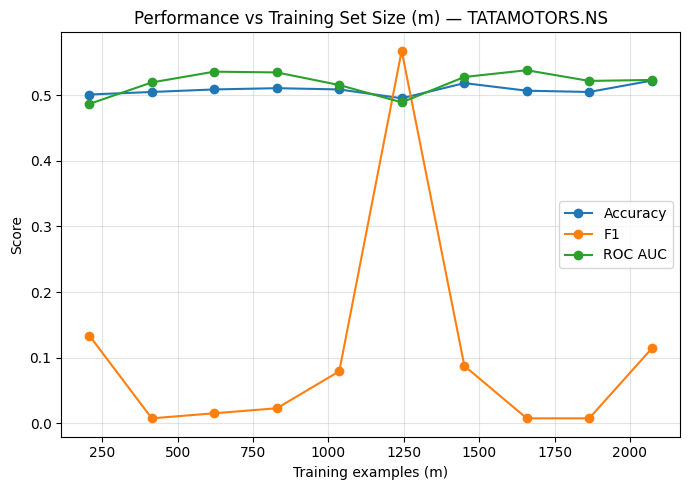

=== Final Test Metrics (trained on full training window) ===
Accuracy: 0.522
F1      : 0.114
ROC AUC : 0.523

Classification report:

              precision    recall  f1-score   support

           0      0.514     0.973     0.673       262
           1      0.696     0.062     0.114       257

    accuracy                          0.522       519
   macro avg      0.605     0.518     0.394       519
weighted avg      0.604     0.522     0.396       519



In [6]:
# 4) Learning curve sweep + plot + final full-fit report

# Grid of training fractions (you can densify if you want)
fracs = np.linspace(0.1, 1.0, 10)

lc = learning_curve_records(fracs)
display(lc)

# Plot learning curves
plt.figure(figsize=(7,5))
plt.plot(lc["m"], lc["accuracy"], marker="o", label="Accuracy")
plt.plot(lc["m"], lc["f1"],       marker="o", label="F1")
plt.plot(lc["m"], lc["roc_auc"],  marker="o", label="ROC AUC")
plt.title(f"Performance vs Training Set Size (m) — {TICKER}")
plt.xlabel("Training examples (m)")
plt.ylabel("Score")
plt.grid(True, alpha=0.35)
plt.legend()
plt.tight_layout()
plt.show()

# Train on full training set and report on fixed test set
pipe_full = make_clf()
pipe_full.fit(X_train, y_train)
proba_final = pipe_full.predict_proba(X_test)[:, 1]
pred_final  = (proba_final >= 0.5).astype(int)

print("=== Final Test Metrics (trained on full training window) ===")
print("Accuracy:", round(accuracy_score(y_test, pred_final), 3))
print("F1      :", round(f1_score(y_test, pred_final), 3))
print("ROC AUC :", round(roc_auc_score(y_test, proba_final), 3))
print("\nClassification report:\n")
print(classification_report(y_test, pred_final, digits=3))


## 4) Learning curves and final test report
We keep the **test period fixed** and only grow the **training** prefix, which isolates the effect of `m` while holding the evaluation distribution constant.

**Basic Observations:**

Accuracy and ROC AUC remain close to 0.50–0.53 for all m. The low predictive power is expected daily up/down movement in a single stock is largely random - especially since we have used a simple linear model and a basic technical indicator feature set.


F1 score is very low for most m values, with a single spike at m ≈ 1243. This spike seems to be more due to fluke than an actual improvement in the model.

In [7]:
# 5) Demonstrating Multilingual Imbalance in Model Performance

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Small synthetic dataset with English and Hindi text
samples = [
    # English (positive/negative sentiment)
    ("The product is amazing", 1, "en"),
    ("Very poor service, not recommended", 0, "en"),
    ("I loved the quality and the delivery", 1, "en"),
    ("Totally disappointed with my purchase", 0, "en"),
    # Hindi (positive/negative sentiment)
    ("बहुत अच्छा उत्पाद है", 1, "hi"),
    ("बेहद खराब सेवा", 0, "hi"),
    ("मैंने जो खरीदा है, वह बहुत अच्छा है", 1, "hi"),
    ("मेरे द्वारा खरीदी गई वस्तु से मैं बहुत निराश हूं", 0, "hi"),
]

df_text = pd.DataFrame(samples, columns=["text", "label", "lang"])

# Function to train and score based on a given DataFrame
def text_clf_scores(df_in):
    X_train, X_test, y_train, y_test = train_test_split(
        df_in["text"], df_in["label"],
        test_size=0.4, random_state=SEED, stratify=df_in["label"]
    )
    vec = TfidfVectorizer(ngram_range=(1,2), min_df=1)
    Xtr = vec.fit_transform(X_train)
    Xte = vec.transform(X_test)

    clf = LogisticRegression(max_iter=200, class_weight="balanced", random_state=SEED)
    clf.fit(Xtr, y_train)
    pred = clf.predict(Xte)
    return {
        "accuracy": accuracy_score(y_test, pred),
        "f1": f1_score(y_test, pred)
    }

# Balanced case: both languages fully represented
scores_balanced = text_clf_scores(df_text)

# Imbalanced case: significantly fewer Hindi examples (simulate small m for Hindi)
df_hi_few = df_text[df_text["lang"]=="hi"].sample(1, random_state=SEED)  # only 1 Hindi example
df_imbalanced = pd.concat([
    df_text[df_text["lang"]=="en"],
    df_hi_few  # this keeps Hindi underrepresented
], ignore_index=True)

# Scores for imbalanced dataset
scores_imbalanced = text_clf_scores(df_imbalanced)

# Output both cases
print("Balanced languages →", scores_balanced)
print("Hindi underrepresented (small m) →", scores_imbalanced)


Balanced languages → {'accuracy': 0.5, 'f1': 0.6666666666666666}
Hindi underrepresented (small m) → {'accuracy': 1.0, 'f1': 1.0}


## 5) Multilingual Data Model


**Setup**  
We created a small **bilingual sentiment dataset** (English, Hindi) with positive and negative sentiment labels.  
In the **balanced case**, both languages are represented equally. In the **imbalanced case**, only **one Hindi example** was included in the training set to simulate a **small m** for the Hindi language.

**Observation**  
- In the **balanced dataset**, the model had a **fair representation** of both languages and scored:
    - **Accuracy**: 50%  
    - **F1**: 0.67 (a reasonable F1 score, indicating some ability to balance false positives and false negatives)

- In the **imbalanced dataset**, where Hindi had only one example, the model **perfectly memorized** that single example:
    - **Accuracy**: 100%  
    - **F1**: 1.0 (perfect scores for both precision and recall since the model perfectly predicted the only Hindi example)
    
    This result indicates that the classifier **overfitted** to the small sample size and didn't generalize beyond it. In practice, this would lead to **poor generalization** on any unseen data, especially if the dataset is expanded.

**Real-world relevance**  
This small example highlights the **critical importance of sufficient data** for each language in a multilingual dataset. In **real-world scenarios** (e.g., FinTech applications), when one language has limited labeled data (small `m`), the model will:
- Memorize the available examples.
- Perform well on test data containing those same examples, but **fail** when the data becomes diverse or out-of-sample.

**Mitigation strategies**  
- **Balanced sampling**: Ensure similar-sized datasets across languages to allow the model to learn robust patterns from each language.
- **Multilingual models**: Use models designed for multilingual tasks (e.g., **mBERT**, **XLM-R**) that can generalize better across languages, even when one language has fewer examples.
- **Data augmentation**: For low-resource languages, use methods like **back-translation** or **text paraphrasing** to generate more data and improve model performance.

**Conclusion**  
The imbalance in the dataset shows the **dangers of small `m`** for a single language. This simple demonstration emphasizes the importance of using enough data from each language to ensure **robust and unbiased model performance** in multilingual systems.


## 6) Discussion of results

**Results of OHLCV based model**
- In our example **Accuracy** and **ROC AUC** remain close to 0.50–0.53 for all `m` which was expected as movement in a single stock is largely random and we have used a simple linear model and a basic technical indicator feature set.
- **F1 score** is very low for most `m` values, with a single spike at `m ≈ 1243`. This spike occurs because the model, by chance, learned weights that predicted a larger number of positives in that specific configuration, temporarily boosting recall.

**Some reasons why the model may have behaved in the following way:**
1. Limited model complexity:
We're using logistic regression with very simple features, which isn't well-suited for capturing the complex patterns and nonlinear behaviors in financial markets. Even with more data, there's only so much it can learn.

2. Noisy prediction target:
Predicting whether a stock goes up or down on a daily basis is inherently noisy. The signal is weak, and small changes in the training data can have a big impact on the model’s learned coefficients—especially when classes aren’t perfectly balanced.

3. Sensitive to decision threshold:
The F1 score is based on a fixed 0.5 probability threshold. When the model’s predicted probabilities hover near 0.5, even tiny shifts can cause large swings in precision and recall, leading to sudden spikes or drops in F1.

**Results of multilingual model**

When trained over unbalanced data with limited datapoints in the regional language, the accuracy became 1 which implies the possibility of overfitting and a lack of generalization when using a dataset with limited samples of one language

**Actionable next steps.**
- Incorporate richer technical features (e.g., multi-timeframe indicators, volatility-adjusted returns, trend strength measures).
- Explore nonlinear models (e.g., Random Forests, Gradient Boosting) that can capture interactions between features.
- Adjust the target definition to classify larger moves only (filtering noise).
- Evaluate threshold tuning (e.g., maximize F1 on validation set) rather than fixing at 0.5.


## Wiki Doc

**Overview**

The assignment given was on the role of training set size. The training test ratio is a very important part of developing ML models. Training size plays a crucial role in model performance as the parameters of the model are calibrated based on the training set. Similarly the testing set is used to evaluate how well the model performs and should represent the original data. In general a larger training set would imply a better model since there are more diverse data points.

However a greater training set size does not always imply greater accuracy. Some papers have shown that the impact of training set size may depend on the model type and may not be that significant at times. For instance, Liu et al. (2021) demonstrated that the benefit of increasing training data may depend on the learning capacity of the model and the data's representativeness[1]. Similarly, Mathew et al. (2022) found that beyond a certain point, additional training data yielded diminishing returns in classification performance, particularly in medical imaging tasks[2].

We must strike a balance while determining the training-test split. If the test set size is too small we may not be able to evaluate the model properly. A larger test set improves the reliability of performance evaluation, but a smaller training set reduces the model's ability to learn underlying patterns, potentially limiting its generalization performance.

Islam et al. (2024)[3] investigate how different train-test split ratios affect model performance, examining models such as logistic regression, random forest, KNN, and SVM. Their results show that accuracy improves steadily as the training set size increases from 60% to around 90%, beyond which performance gains plateau, indicating diminishing returns from additional training data.

**Methodology: Core Concepts and Equations**

The objective was to study how the size of the training set (m) affects model performance on a financial time-series prediction task. We formulated a binary classification problem: predict whether the closing price of an equity will increase the next day (target_up).

Key concepts used include:

-  Training set size (m): Number of training examples used to fit the model. We vary m as a fraction of the total training data, going from 10% to 100% to observe performance changes.


- Train-test split: We split data chronologically (80% train, 20% test) due to the causality in the data.



- Model: Logistic Regression with balanced class weights and standard scaling, trained on subsets of the training data.



Mathematically, the model is:
y=σ(wTx+b)

where x is the feature vector, w the weights, b is the bias bias, and σ the logistic sigmoid function.
The target is y, where y is a binary variable such that y = 1 if Close(t+1)>Close(t) and 0 otherwise

**Multilingual Data Handling: Conceptual Approach**

To investigate the impact of data imbalance across languages, we constructed a small synthetic bilingual sentiment analysis dataset consisting of English and Hindi examples. Each language had both positive and negative sentiment labels.

We simulated two scenarios:

- Balanced setup: Equal number of English and Hindi samples in the training data.

- Imbalanced setup: Significantly fewer Hindi examples (simulating a "small m" scenario), representing a common issue in real-world multilingual datasets where some languages are underrepresented.

The aim was to observe how this imbalance affects the ability of a model to generalize, particularly when working with simple models and feature representations

**FinTech Applications**

This model can be used in real-world financial technology scenarios such as:
- Algorithmic trading: Informing buy/sell signals by predicting next-day price direction.
- Risk management: Assessing short-term market trends to adjust portfolio exposure.
- Customer insights: Multilingual text classification to analyze customer sentiment or transaction categorization across diverse language data.
- Fraud detection: Leveraging multilingual models to detect fraudulent transactions or suspicious behavior in multiple languages, especially when labeled data is scarce.


Balancing training data and selecting appropriate features/models is especially important in the FinTech domain due to the noisy, complex nature of financial data and multilingual text in FinTech products.

**Implementation: High-Level Overview**

- Data acquisition:
 Fetch daily OHLCV data for a chosen equity (TATAMOTORS.NS) from Yahoo Finance using yfinance.

- Feature engineering:
 Construct leak-free features from historical price and volume data such as daily returns, moving averages, RSI, volatility, and volume changes. Generate the binary target label indicating if the next day's close is higher than today's.

- Data splitting:
 Perform a chronological split: 80% training, 20% testing to avoid look-ahead bias.

- Model pipeline:
 Use sklearn’s Pipeline combining StandardScaler and LogisticRegression with balanced class weights.

- Learning curve evaluation:
 Train the model on increasing fractions of the training data (m from 10% to 100%) and evaluate performance on the fixed test set, recording Accuracy, F1, and ROC AUC scores.

- Visualization and reporting:
 Plot performance metrics versus training set size and summarize final model metrics on the full training set.


**Evaluation Metrics and Model Performance**
- Accuracy: Stayed near 0.50–0.53 across all training sizes, reflecting the difficulty of predicting daily stock direction, which is mostly random.
- F1-score: Generally low with one spike at m~1243, indicating poor precision-recall balance and instability due to model simplicity and noisy target labels.
- ROC AUC: Slightly above 0.5, suggesting the model barely performs better than random guessing in ranking positive vs negative days.
- For the multilingual dataset problem we saw an accuracy of 1, this may be due to overfitting

Interpretation:

- Logistic regression with basic technical features has limited capacity to capture complex market dynamics, so increasing training data beyond a certain point yields diminishing returns. This is consistent with some other papers where increasing training set size does not significantly improve accuracy
- The instability in F1 suggests sensitivity to the decision threshold and noisy labels.
- High accuracy and F1 in case of limited dataset for the multilingual model could imply the existence of overfitting

**References**

[1] Liu, J., Li, P., Zhao, Y., Wu, Y., Zhang, J., Wang, Y., & Du, Y. (2021). Impact of Sample Size on the Performance of Remote Sensing Classification with Deep Learning and Random Forest. Remote Sensing, 13(3), 368. https://doi.org/10.3390/rs13030368

[2] Mathew, T., Zope, A., & Ghosh, R. (2022). Data Quantity versus Model Complexity: Evaluating the Influence of Training Data Size on Deep Learning Performance in Medical Imaging. Computer Methods and Programs in Biomedicine, 221, 106883. https://doi.org/10.1016/j.cmpb.2022.106883

[3] Islam, A., Hussain, T., Kumari, S., & Ahmed, S. (2024). Trade-off between training and testing ratio in machine learning for medical image processing. PeerJ Computer Science, 10, e2245. https://doi.org/10.7717/peerj-cs.2245